In [2]:
import nltk
import pandas as pd
import numpy as py
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
#For Pre_Processing
import string
nltk.download('punkt')
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\umerh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
spam_data = pd.read_csv('SpamFilter.csv')
spam_data.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [4]:
spam_data.info()
print (f'Total number of unique vales in text column is: {spam_data['text'].nunique()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB
Total number of unique vales in text column is: 5695


In [5]:
spam_data.isnull().sum()

text    0
spam    0
dtype: int64

In [6]:
print(spam_data.duplicated().sum())

33


In [7]:
spam_data.drop_duplicates(inplace=True)
spam_data.duplicated().sum()
spam_data = spam_data.rename(columns = {'text':'Mail', 'spam':'Label'})
spam_data.head()

,Mail,Label
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [8]:
spam_data['Length'] = spam_data['Mail'].apply(len)
spam_data.head()
spam_data.sort_values(by='Length', ascending = False).head(4)

,Mail,Label,Length
2650,Subject: from the enron india newsdesk - april...,0,43952
1380,Subject: from the enron india newsdesk - april...,0,43937
2338,Subject: from the enron india newsdesk - april...,0,31055
536,Subject: make thousands just sending emails . ...,1,28432


In [9]:
def preprocess_text(text):
    # Remove punctuation
    no_punctuation = ''.join([char for char in text if char not in string.punctuation])

    # Lowercase the text
    no_punctuation_lower = no_punctuation.lower()

    # Tokenize the text into words
    words = nltk.word_tokenize(no_punctuation_lower)

    # Join the tokenized words back into a sentence
    text = ' '.join(words)

    return text

In [10]:
spam_data['Preprocessed_Mail'] = spam_data['Mail'].apply(preprocess_text)
spam_data.head()

,Mail,Label,Length,Preprocessed_Mail
0,Subject: naturally irresistible your corporate...,1,1484,subject naturally irresistible your corporate ...
1,Subject: the stock trading gunslinger fanny i...,1,598,subject the stock trading gunslinger fanny is ...
2,Subject: unbelievable new homes made easy im ...,1,448,subject unbelievable new homes made easy im wa...
3,Subject: 4 color printing special request add...,1,500,subject 4 color printing special request addit...
4,"Subject: do not have money , get software cds ...",1,235,subject do not have money get software cds fro...


<Axes: xlabel='Label', ylabel='count'>

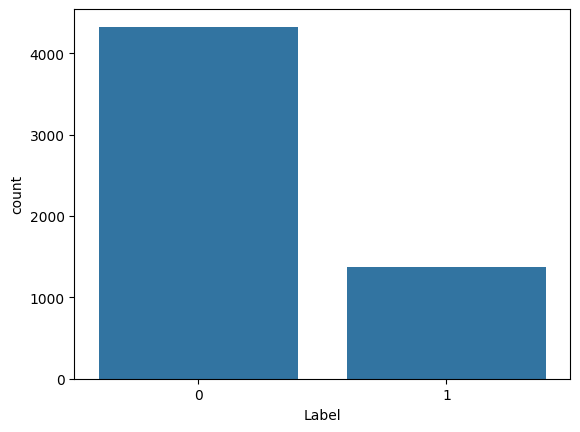

In [11]:
sns.countplot(data = spam_data, x = 'Label')

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

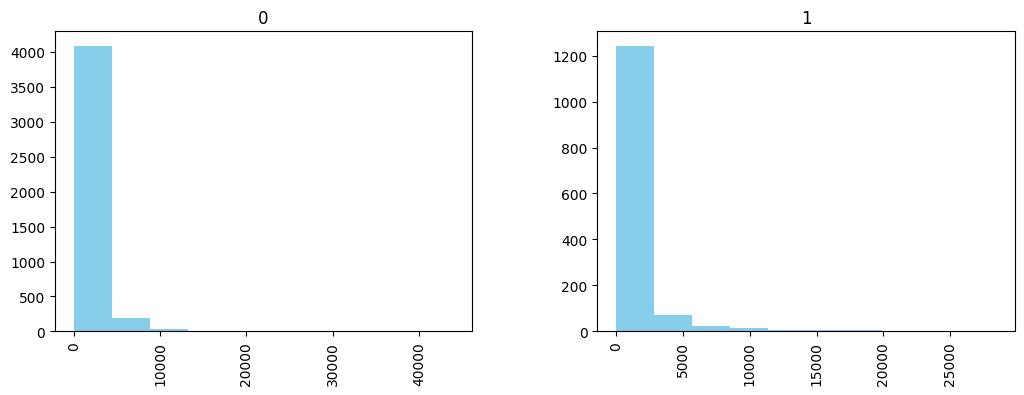

In [12]:
spam_data.hist(column = 'Length', by ='Label',figsize=(12,4), bins = 10,color='skyblue')

In [13]:
def plot_ngrams(texts1, texts2, n=2, top_k=25, texts1_name = 'Spam_Mails', texts2_name = 'Ham Mails'):
    def extract_ngrams(texts):
        # Create the CountVectorizer for n-grams
        vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
        X = vectorizer.fit_transform(texts)

        # Sum up the counts of each n-gram
        counts = X.sum(axis=0).A1
        ngrams = vectorizer.get_feature_names_out()
        ngram_counts = pd.DataFrame({'ngram': ngrams, 'count': counts})

        # Sort the n-grams by their counts in descending order
        ngram_counts = ngram_counts.sort_values('count', ascending=False).head(top_k)
        
        return ngram_counts
    
    # Extract n-grams for texts1 and texts2
    ngram_counts1 = extract_ngrams(texts1)
    ngram_counts2 = extract_ngrams(texts2)
    
    # Plotting side by side
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot for texts1
    sns.barplot(ax=axes[0], x='count', y='ngram', data=ngram_counts1)
    axes[0].set_title('Top {} {}-grams - {}'.format(top_k, n, texts1_name))
    axes[0].set_xlabel('Count')
    axes[0].set_ylabel('{}-gram'.format(n))

    # Plot for texts2
    sns.barplot(ax=axes[1], x='count', y='ngram', data=ngram_counts2)
    axes[1].set_title('Top {} {}-grams - {}'.format(top_k, n, texts2_name))
    axes[1].set_xlabel('Count')
    axes[1].set_ylabel('{}-gram'.format(n))

    plt.tight_layout()
    plt.show()

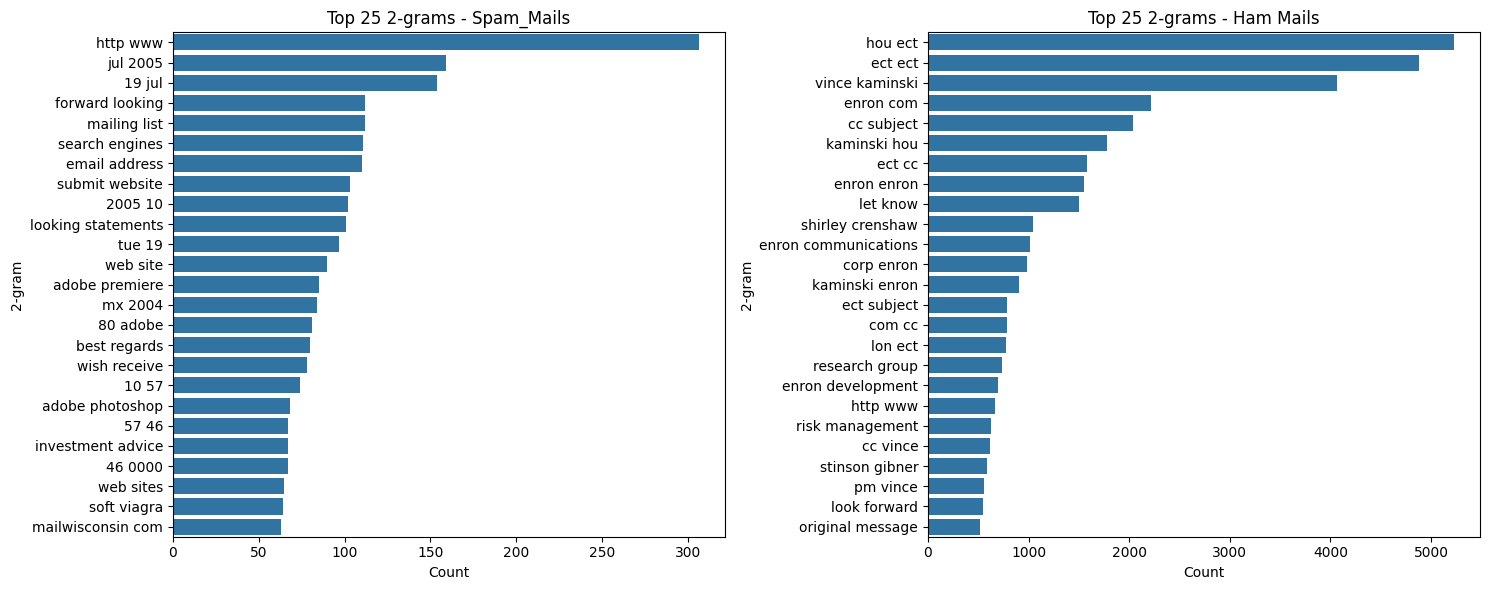

In [16]:
spam_mails = spam_data[spam_data['Label'] == 1]['Preprocessed_Mail']
non_spam_mails = spam_data[spam_data['Label'] == 0]['Preprocessed_Mail']
plot_ngrams(spam_mails, non_spam_mails, 2)

In [17]:
# TF-IDF
feature_extraction = TfidfVectorizer(min_df = 1, stop_words = 'english', lowercase = True)
feature_extraction.fit_transform(spam_data['Preprocessed_Mail'])
text_tfidf = feature_extraction.fit_transform(spam_data['Preprocessed_Mail'])

In [32]:
x_train, x_test, y_train, y_test = train_test_split(text_tfidf, spam_data["Label"], test_size=0.25)

print(f"train dataset features size: {x_train.shape}")
print(f"train dataset label size: {y_train.shape}")
print(f"test dataset features size: {x_test.shape}")
print(f"test dataset label size: {y_test.shape}")

train dataset features size: (4271, 37022)
train dataset label size: (4271,)
test dataset features size: (1424, 37022)
test dataset label size: (1424,)


In [33]:
model = MultinomialNB()
model.fit (x_train, y_train)

MultinomialNB()

In [34]:
prediction = model.predict (x_test)
prediction

array([0, 0, 0, ..., 0, 0, 0])

In [35]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1088
           1       1.00      0.64      0.78       336

    accuracy                           0.91      1424
   macro avg       0.95      0.82      0.86      1424
weighted avg       0.92      0.91      0.91      1424



In [36]:
print(accuracy_score(y_test, prediction)*100)

91.43258426966293


Text(0.5, 1.0, 'Confusion Matrix')

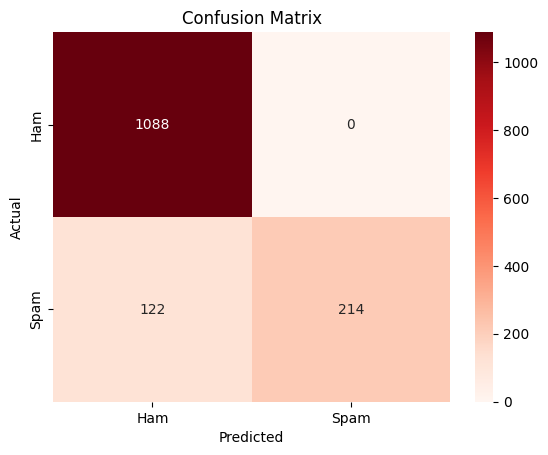

In [37]:
conf_matrix = confusion_matrix(y_test, prediction)
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Reds', cbar = True, xticklabels = ['Ham', 'Spam'], yticklabels = ['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

In [38]:
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
specificity = TN / (TN + FP)

print("Accuracy : ",accuracy)
print("Precision : ",precision)
print("Recall : ",recall)
print("Specificity : ",specificity)

Accuracy :  0.9143258426966292
Precision :  1.0
Recall :  0.6369047619047619
Specificity :  1.0


In [39]:
def check_spam(text):
    text = preprocess_text(text)
    text_tfidf_new = feature_extraction.transform([text])
    predict = model.predict(text_tfidf_new)
    if predict[0] == 0:
        return ('Ham Mail !')
    else:
        return ('Spam Mail !')

In [40]:
check_spam('Subject: hvince , edge effectiveness testing for fas 133  vince ,  as we discussed , subject to minor changes the attached paper will appear in  the j of applied corporate planning . i \'d be most interested in your  comments .  by the way , if you like the yield curve generation process described in the  paper , we \'d be happy to perform a simulation , so that you can compare the  results based on the to the hjm procees .  i look forward to getting together with you when you come to ny to attend  the garp conference , around february 13 . just give me a brief warning .  regards ,  andy  andrew kalotay associates , inc .  ( 212 ) 482 - 0900  andy @ kalotay . com  visit our web - site http : / / www . kalotay . com  - fasl 33 article . doc ')


'Ham Mail !'

In [41]:
import gradio as gr
inputs = gr.Textbox(label = 'Mail')
outputs = gr.Textbox(label = 'Ham/Spam')

gr.Interface(fn=check_spam, inputs=inputs, outputs=outputs, title="Email Spam Checker", description="Predicts the genuinity of a mail based on its text.").launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://25118988566bd8b0bf.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
